In [189]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt # for making figures
from torch.utils.data import random_split
%matplotlib inline

In [190]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(min(len(w) for w in words))
print(words[:8])

32033
15
2
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [267]:
char_start = "."
char_end = "!"
char_pad = "-"

chars = sorted(list(set(''.join(words))))
chars.append(char_start)
chars.append(char_end)
chars.append(char_pad)

ctoi = { c:i for i, c in enumerate(chars)}
itoc = { i:c for i, c in enumerate(chars)}
vocab_size = len(chars)

idx_start = ctoi[char_start]
idx_end = ctoi[char_end]
idx_pad = ctoi[char_pad]

print(ctoi)
print(vocab_size)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '.': 26, '!': 27, '-': 28}
29


In [214]:
train_wd, valid_wd, test_wd = random_split(words, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(420))

In [215]:
def right_pad(string, char, length):
    d = length - len(string)
    return string + char * d
    
pad("apple", char_pad, 10)

'apple-----'

### Building Dataset

Each example is padded with starting symbols (`.`), ending symbol (`!`), and right-padding symbols (`-`). The right-padding is used to make each example the same length so that mini-batch could be used.

The number of pad equals to kernal size of conv layer. i.e. when context_size = 4

Input:
```
....emma---
....steven-
```

Output:
```
emma!-----
steven!---
```

In [233]:
context_size = 4

def char_idx(word):
    return [ctoi[c] for c in word]

def build_dataset(words):
    max_len = max(len(w) for w in words)
    
    x_len = max_len + context_size # start pad + end pad
    y_len = max_len + 1
    
    X = []
    Y = []
    
    for w in words:
        x = char_start * context_size + w
        x = right_pad(x, char_pad, x_len)
        
        y = w + char_end
        y = right_pad(y, char_pad, y_len)
        
        X.append(char_idx(x))
        Y.append(char_idx(y))
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

train_x, train_y = build_dataset(train_wd)
valid_x, valid_y = build_dataset(valid_wd)

In [236]:
train_x.shape, train_y.shape

(torch.Size([25627, 19]), torch.Size([25627, 16]))

In [237]:
print(train_wd[0])
print(train_x[0])

jaysen
tensor([26, 26, 26, 26,  9,  0, 24, 18,  4, 13, 28, 28, 28, 28, 28, 28, 28, 28,
        28])


In [220]:
class Transpose(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.T
    
    def string(self):
        return "Transpose"

In [221]:
class Permute(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.permute(self.dim)
    
    def string(self):
        return "Permute"

In [222]:
class Inspect(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.x = x
        return x

In [257]:
@torch.no_grad()
def eval_split(xs, ys):
    logits = model(xs)
    N, L, C = logits.shape
    logits = logits.view(-1, C)
    ys = ys.view(-1)
    loss = F.cross_entropy(logits, ys, ignore_index=idx_pad)
    
    return loss.item()

The input seq length is: `word_length + 4` (4 is context length)

- seq length after 1st conv: `word_length + 3`
- seq length after 2nd conv: `word_length + 2`
- seq length after 3nd conv: `word_length + 1` (+1 because we want the model to predict end char)


In [283]:
embed_size = 24
hidden_size = 128

# input (batch, seq)
model = nn.Sequential(
    nn.Embedding(vocab_size, embed_size), # (batch, seq, embed)
    Permute((0, 2, 1)), # (batch, seq, embed)

    # num of conv layer = context_size - 1
    nn.Conv1d(in_channels=embed_size, out_channels=hidden_size, kernel_size=2), # (batch, hidden, seq)
    nn.Tanh(),

    nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=2), # (batch, hidden, seq)
    nn.Tanh(),

    nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=2), # (batch, hidden, seq)
    nn.Tanh(),

    Permute((0, 2, 1)), # (batch, seq, embed)
    
    nn.Linear(hidden_size, vocab_size), # (batch, seq, vocab)
)

for p in model.parameters():
    p.requires_grad = True
    
print(sum((p.nelement() for p in model.parameters())))

76501


In [284]:
import random

train_ds = torch.utils.data.TensorDataset(train_x, train_y)
train_dl = torch.utils.data.DataLoader(train_ds, 32, shuffle=True)

optimizer = torch.optim.Adam(model.parameters())
lossi = []
epoch = 5

for i in range(epoch):
    for xs, ys in train_dl:
        optimizer.zero_grad()
        
        logits = model(xs) # (batch, seq, vocab)
        
        N, L, C = logits.shape
        logits = logits.view(-1, C) # (batch, seq, vocab) -> (batch * seq, vocab)
        ys = ys.view(-1) # (batch, seq) -> (batch * seq)
                
        loss = F.cross_entropy(logits, ys, ignore_index=idx_pad)
        loss.backward()

        optimizer.step()
        lossi.append(loss.item())

    print(f"{i+1:2d}/{epoch}: {lossi[-1]:.4f}")

 0/5: 2.2210
 1/5: 2.1592
 2/5: 2.2303
 3/5: 2.0156
 4/5: 2.0890


In [285]:
valid_loss = eval_split(valid_x, valid_y)
train_loss = eval_split(train_x, train_y)

print(f"train: {train_loss:.4f}")
print(f"valid: {valid_loss:.4f}")
print(f"baseline (random):: { -torch.tensor(1/26).log() }")

train: 2.0200
valid: 2.0742
baseline (random):: 3.25809645652771


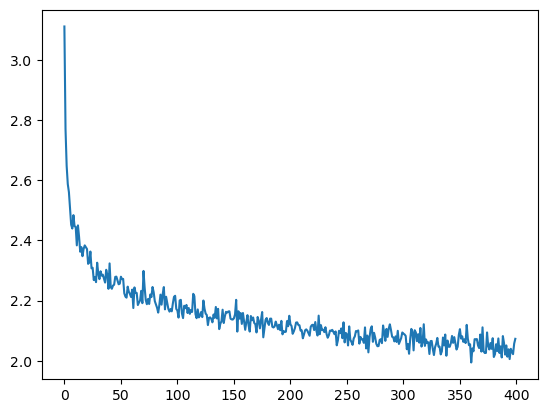

In [286]:
bucket = 10
clip = len(lossi) - (len(lossi) % bucket)

l = torch.tensor(lossi[0:clip])
l = l.view(-1, bucket).mean(1)
plt.plot(l)

#### Log

Single example stocastic gradient
- train: 2.2232
- valid: 2.2155
  
Mini-batch gradient descent (embed_size: 16, hidden_size: 64)
- train: 2.0666
- valid: 2.1058

3 layers casual conv, single example (kernel = 4, 3 conv layer, embed_size = 10, hidden_size = 128)
- train: 2.1893
- valid: 2.1989

3 layers casual conv, mini-batch (kernel = 4, 3 conv layer, embed_size = 24, hidden_size = 128)
- train: 2.0200
- valid: 2.0742

In [295]:
for _ in range(10):
    sample = [idx_start] * context_size

    while(True):
        ctx = sample[-context_size:] 
        ctx = torch.tensor(ctx).view(1, -1) # (batch=1, seq)
        logits = model(ctx) # (batch=1, seq=1, vocab)
        
        logits = logits.view(-1) # (vocab)
        prob = F.softmax(logits, 0)
        idx = torch.multinomial(prob, 1).item()
        sample.append(idx)

        if idx == idx_end or len(sample) > 50:
            break

    word = "".join([itoc[idx] for idx in sample[context_size:-1]])
    print(word)

royell
amri
triya
charlet
eserdic
matvie
annim
thoselycia
morlon
ruton
